<a href="https://colab.research.google.com/github/aaubs/ds-master/blob/main/notebooks/M3_1_LSTM_Tutorial_v2_Exercise_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-on Learning Project: S&P 500 stock data


In [1]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load the stock data
stock_data = pd.read_csv('https://raw.githubusercontent.com/rashida048/Datasets/master/stock_data.csv')

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(stock_data[['Open', 'High', 'Low', 'Close', 'Volume']])
data_s = pd.DataFrame(data_scaled, columns=['Open', 'High', 'Low', 'Close', 'Volume'])
stock_data = data_s[['Open']].to_numpy()

In [3]:
data_s

,Open,High,Low,Close,Volume
0,0.478567,0.497726,0.469931,0.499531,0.051098
1,0.502503,0.508390,0.501102,0.500469,0.042665
2,0.497966,0.505724,0.502361,0.509222,0.024962
3,0.528473,0.534577,0.533060,0.535480,0.062994
4,0.531915,0.535989,0.533375,0.538762,0.032843
...,...,...,...,...,...
3014,0.974969,0.978360,0.980479,0.978900,0.020720
3015,0.967459,0.970833,0.955447,0.952016,0.015136
3016,0.949155,0.956719,0.956392,0.955142,0.010099
3017,0.954631,0.954054,0.953558,0.951391,0.012876


In [4]:
# Split the data into sequences for RNN input
sequence_length = 30
sequence_data = []
sequence_labels = []
for i in range(len(stock_data) - sequence_length):
    sequence_data.append(stock_data[i:i+sequence_length])
    sequence_labels.append(stock_data[i+sequence_length])
sequence_data = np.array(sequence_data)
sequence_labels = np.array(sequence_labels)

train_data = sequence_data[:2000]
train_labels = sequence_labels[:2000]
test_data = sequence_data[2000:]
test_labels = sequence_labels[2000:]

In [5]:
# Split the data into training and testing sets
train_data = TensorDataset(torch.from_numpy(train_data), torch.from_numpy(train_labels))
test_data = TensorDataset(torch.from_numpy(test_data), torch.from_numpy(test_labels))

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

#### RNN Solution

In [6]:
# The RNN model
# Initializing Hyperparameters
epochs = 5
lr = 0.3

# 1. Creating a FeedForwardNetwork
# 1.1 Structure (Architecture) of NN
# Define the input size, hidden size and number of outputs
input_size = 1
hidden_size = 6
sequence_length = 30
output_size = 1

batch_size = 1

rnn = torch.nn.RNN(input_size, hidden_size, batch_first=True)
# Initialize the output layer
fc = torch.nn.Linear(hidden_size, output_size)


# 1.2 Loss Function
loss_mse = torch.nn.MSELoss()

# 1.3 Optmization Approch
optimizer = torch.optim.SGD(rnn.parameters(), lr=lr)

Training: 100%|██████████| 5/5 [00:35<00:00,  7.03s/it]


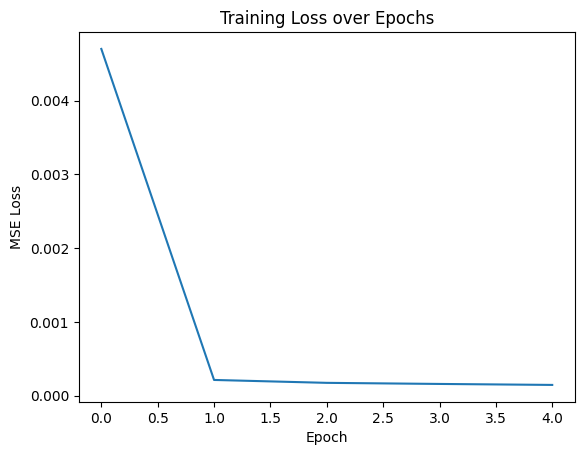

Test MSE: 0.010636047611000262


In [8]:
# Train the RNN model
train_losses = []
test_losses = []

# Loop over the number of epochs
for epoch in tqdm(range(epochs), desc='Training'):
    train_loss = 0

    # Initialize the hidden state and the cell state
    # The hidden state resets to zero for every epoch
    hs = torch.zeros(1, batch_size, hidden_size)

    # Get the input and target at position i
    for i, (data, label) in enumerate(train_loader):

        # 2. Forward Pass
        output, hidden = rnn(data.float(), hs)
        output_fc = fc(hidden[-1])

        # 3. FeedForward Evaluation
        loss = loss_mse(output_fc, label.float())
        hs = hs.detach()

        # 4. Backward Pass / Gradient Calculation
        loss.backward()

        # Store the loss for each epoch
        train_loss += loss.item()

        # 5. Back Propagation / Update Weights
        optimizer.step()
        optimizer.zero_grad()

    # Calculate the average training loss
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

# Plot the MSE loss for each epoch
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.show()

# Evaluate the RNN model
mse = 0

with torch.no_grad():
    hidden = torch.zeros(1, data.size(0), hidden_size)
    for data, label in test_loader:
        output, hidden = rnn(data.float(), hidden)
        output_fc = fc(hidden[-1])

        mse += ((output_fc - label)**2).mean().item()

mse /= len(test_loader)
print('Test MSE: {}'.format(mse))

#### LSTM Solution

In [9]:
# Initializing Hyperparameters
epochs = 5
lr = 0.3

train_losses = []
test_losses = []

# 1. Creating a FeedForwardNetwork
# 1.1 Structure (Architecture) of NN
# Define the input size, hidden size and number of outputs
input_size = 1
hidden_size = 6
sequence_length = 30
output_size = 1

batch_size = 1


lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
# Initialize the output layer
fc = torch.nn.Linear(hidden_size, output_size)


# 1.2 Loss Function
loss_mse = torch.nn.MSELoss()

# 1.3 Optmization Approch
optimizer = torch.optim.SGD(lstm.parameters(), lr=lr)

In [10]:
# Loop over the number of epochs
for epoch in tqdm(range(epochs), desc='Training'):
    total_loss = 0

    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, batch_size, hidden_size)
    cs = torch.zeros(1, batch_size, hidden_size)
    # Get the input and target at position i
    for i, (data, label) in enumerate(train_loader):

        hidden = (hs, cs)
        # 2. Forward Pass
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])

        # 3. FeedForward Evaluation
        loss = loss_mse(output, label.float())
        hs = hs.detach()
        cs = cs.detach()

        # 4. Backward Pass / Gradient Calculation
        loss.backward()

        # Store the loss for each epoch
        train_loss += loss.item()

        # 5. Back Propagation / Update Weights
        optimizer.step()
        optimizer.zero_grad()

    # Calculate the average training loss
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Training: 100%|██████████| 5/5 [00:21<00:00,  4.30s/it]


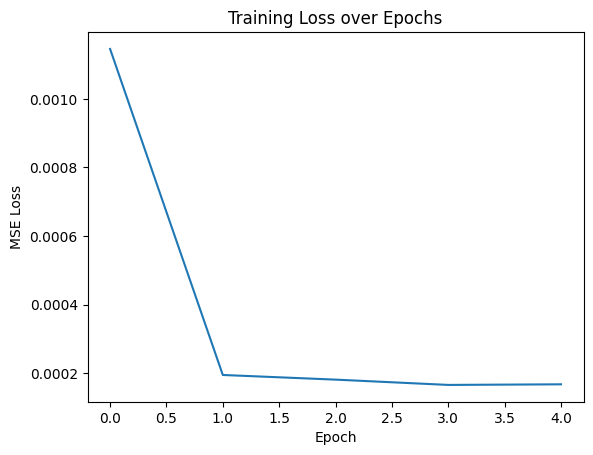

Test MSE: 0.0009373716213308281


In [11]:
# Plot the MSE loss for each epoch
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.show()

# Evaluate the LSTM model
mse = 0

with torch.no_grad():
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, batch_size, hidden_size)
    cs = torch.zeros(1, batch_size, hidden_size)

    for data, label in test_loader:
        hidden = (hs, cs)
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])
        hs = hs.detach()
        cs = cs.detach()

        mse += ((output - label)**2).mean().item()

mse /= len(test_loader)
print('Test MSE: {}'.format(mse))